# Smart Energy AI Project – Cost Optimization Prediction (v2)
**Author:** Tien Manh Nguyen (ML Engineer)

**Purpose:** Train a cost prediction model, analyze feature importance, simulate cost optimization, and document RACI.


In [ ]:
# Standard imports and plotting settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter

sns.set(style="whitegrid")
# Load dataset
df = pd.read_csv("/content/T_ML_Dataset151025.csv", low_memory=False)
print("Rows, Columns:", df.shape)
df.head()

Rows, Columns: (594687, 28)


,device_id,ts,power_w,voltage_v,current_a,relay_on,energy_wh_acc,firmware,location,illuminance_lux,...,outlet_id,is_110v,is_220v,Bracker_amp,max_watts,hour,weekday,Month,is_weekend,is_anomaly
0,1,2024-10-07 23:50:00,732.770186,118.880771,6.163908,1,6660455,1.12.3,77327,0.0,...,1,1,0,30,3800,23,0,10,0,1
1,1,2024-10-07 23:50:00,768.632021,120.267027,6.391045,1,6658628,1.12.3,77327,0.0,...,1,1,0,30,3800,23,0,10,0,1
2,1,2024-10-08 00:00:00,835.137039,119.387939,6.995154,1,139,1.12.3,77327,0.0,...,1,1,0,30,3800,0,1,10,0,1
3,1,2024-10-08 00:10:00,619.227933,119.496472,5.181977,0,242,1.12.3,77327,0.0,...,1,1,0,30,3800,0,1,10,0,0
4,1,2024-10-08 00:20:00,524.165806,118.527716,4.422306,1,330,1.12.3,77327,0.0,...,1,1,0,30,3800,0,1,10,0,1


In [ ]:
# Convert timestamp and drop unhelpful columns
df['ts'] = pd.to_datetime(df['ts'], errors='coerce')

drop_cols = ['firmware', 'Hostname', 'vendor', 'model', 'device_type', 'area', 'outlet_id']
for c in drop_cols:
    if c in df.columns:
        df.drop(columns=c, inplace=True)

df = df.dropna(subset=['ts', 'power_w', 'energy_wh_acc'])
print("Memory footprint (MB):", df.memory_usage(deep=True).sum() / 1e6)
df.info()

Memory footprint (MB): 99.907548
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594687 entries, 0 to 594686
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   device_id            594687 non-null  int64         
 1   ts                   594687 non-null  datetime64[ns]
 2   power_w              594687 non-null  float64       
 3   voltage_v            594687 non-null  float64       
 4   current_a            594687 non-null  float64       
 5   relay_on             594687 non-null  int64         
 6   energy_wh_acc        594687 non-null  int64         
 7   location             594687 non-null  int64         
 8   illuminance_lux      594687 non-null  float64       
 9   presence             594687 non-null  int64         
 10  presence_confidence  594687 non-null  float64       
 11  temp_c_avg           594687 non-null  float64       
 12  is_110v              594687 non-null  i

In [ ]:
# Define energy rate and derive features
ENERGY_RATE = 0.12  # $ per kWh

df = df.sort_values(['device_id','ts']).reset_index(drop=True)
df['energy_wh_delta'] = df.groupby('device_id')['energy_wh_acc'].diff().fillna(0).clip(lower=0)
df['energy_kwh'] = df['energy_wh_delta'] / 1000.0
df['energy_cost'] = df['energy_kwh'] * ENERGY_RATE

df['hour'] = df['ts'].dt.hour
df['weekday'] = df['ts'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)

if 'max_watts' in df.columns:
    df['power_rate'] = df['power_w'] / df['max_watts']
else:
    df['power_rate'] = df['power_w'] / (df['power_w'].max() + 1e-9)

df['voltage_dev'] = (df['voltage_v'] - df['voltage_v'].mean()) / (df['voltage_v'].std() + 1e-9)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(0)
print("After feature creation:", df.shape)
df[['energy_wh_delta','energy_kwh','energy_cost']].head()

After feature creation: (594687, 26)


,energy_wh_delta,energy_kwh,energy_cost
0,0.0,0.000,0.00000
1,87.0,0.087,0.01044
2,111.0,0.111,0.01332
3,92.0,0.092,0.01104
4,136.0,0.136,0.01632


In [ ]:
from sklearn.model_selection import train_test_split

features = ['power_w','voltage_v','current_a','presence','temp_c_avg','hour','weekday','power_rate','voltage_dev']
features = [f for f in features if f in df.columns]
X = df[features]
y = df['energy_cost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (535218, 9) Test shape: (59469, 9)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42, verbose=0)

start = perf_counter()
model.fit(X_train, y_train)
end = perf_counter()
training_time = end - start

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"⏱ Training time: {training_time:.2f} seconds")
print(f"MAE: {mae:.6f}")
print(f"R²: {r2:.6f}")

⏱ Training time: 659.40 seconds
MAE: 0.015986
R²: 0.974570


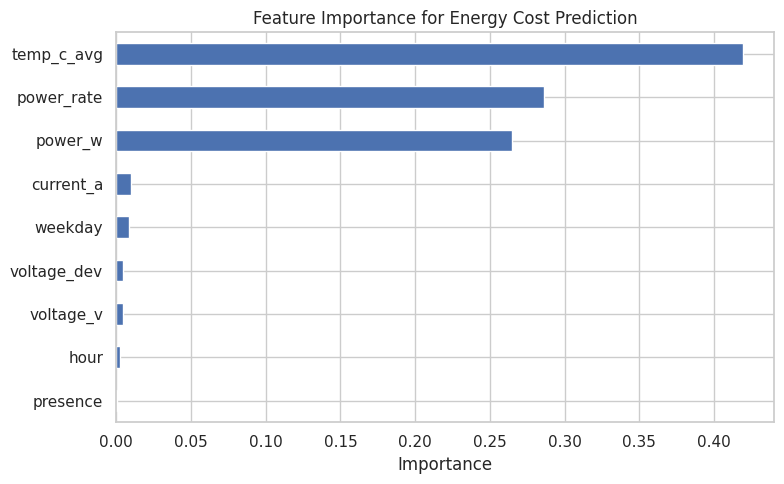

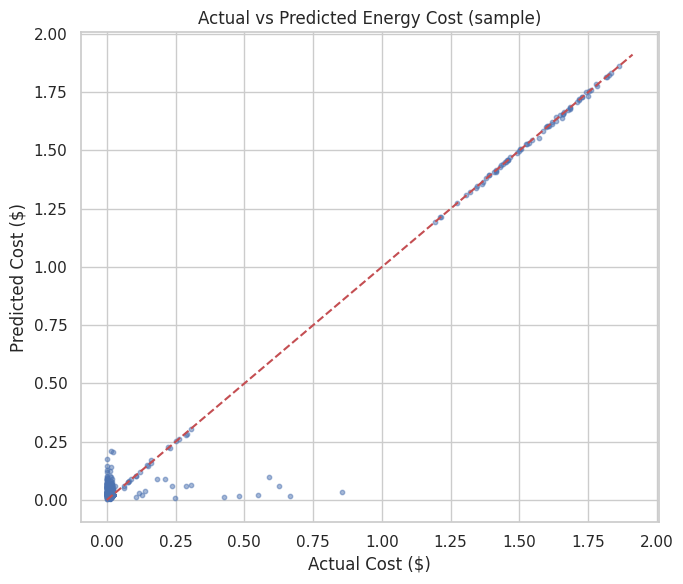

In [ ]:
# Feature importance
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(8,5))
importances.plot(kind='barh')
plt.title("Feature Importance for Energy Cost Prediction")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# Actual vs Predicted (sample)
import numpy as np
sample_idx = np.random.choice(np.arange(len(y_test)), size=min(1000, len(y_test)), replace=False)
plt.figure(figsize=(7,6))
plt.scatter(y_test.iloc[sample_idx], y_pred[sample_idx], alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Cost ($)")
plt.ylabel("Predicted Cost ($)")
plt.title("Actual vs Predicted Energy Cost (sample)")
plt.tight_layout()
plt.show()

In [ ]:
# Simulate cost optimization
REDUCTION_FACTOR = 0.5  # 50% reduction when unoccupied
df['optimized_cost'] = df['energy_cost'] * (np.where(df['presence'] == 0, REDUCTION_FACTOR, 1.0))

total_original = df['energy_cost'].sum()
total_optimized = df['optimized_cost'].sum()
savings_percent = (total_original - total_optimized) / (total_original + 1e-9) * 100.0

print(f"Total original cost: ${total_original:.6f}")
print(f"Total optimized cost: ${total_optimized:.6f}")
print(f"Estimated Savings: {savings_percent:.2f}% (using reduction factor {REDUCTION_FACTOR})")

Total original cost: $80074.115280
Total optimized cost: $50492.745960
Estimated Savings: 36.94% (using reduction factor 0.5)


## RACI Matrix

| Role | Task | Responsible | Accountable | Consulted | Informed |
|------|------|-------------|--------------|------------|-----------|
| ML Engineer (You) | Build cost prediction & optimization simulation | ✅ |  | Team Lead | All members |
| Data Engineer | Data ingestion & cleaning |  | ✅ | You | Team |
| IoT Developer | Sensor config & emulator |  |  | ✅ | Team |
| Project Manager | Presentation & milestones |  | ✅ |  | Instructor |

## Conclusion

This notebook trained a Random Forest model to predict per-interval energy cost using IoT features and time features. The model performance and training time are reported above. A simple simulation applying a 50% reduction in cost when presence==0 produced an estimated savings percentage (printed above). The feature importance plot highlights which signals are most useful and informs potential automation rules for cost reduction.
